In [1]:
import xarray as xr
import numpy as np
import os
import sys
import matplotlib.pyplot as plt

In [2]:
############################
# set up 
############################
#
feature_data          = '/glade/work/hardt/data/model2/model2-v1_1999_00minuteAfterHour_3D_refl.nc'
label_data            = '/glade/work/hardt/data/model2/model2-v1_1999_3D_W.nc'
#
model_run             - 'model2'
#
############################

In [3]:
fds = xr.open_dataset(feature_data)
f = fds.REFL_10CM.values

lds = xr.open_dataset(label_data)
l = lds.W.values

t = lds.XTIME.values

In [4]:
print(f.shape)
print(l.shape)

(1224, 50, 256, 256)
(1224, 51, 256, 256)


In [6]:
#
# set up lat lon arrays
#
input_dir = '/glade/work/hardt/data/model2'
#
latlon_filename = 'model2-v1_latlon_coord.nc'
latlonFile = os.path.join(input_dir, latlon_filename)
#
latlon_ds = xr.open_mfdataset(latlonFile, combine='by_coords')
lat = latlon_ds.XLAT[0,:,:].values
lon = latlon_ds.XLONG[0,:,:].values

print(lat.shape)
print(lon.shape)

(256, 256)
(256, 256)


In [ ]:
f = np.max(f[:,:,:,:], axis=1)
l = np.max(l[:,:,:,:], axis=1)

print(f.shape)
print(l.shape)

In [34]:
#
plt_number = 236
#
fi = f[plt_number,:,:]
li = l[plt_number,:,:]
#
print(fi.shape)
print(li.shape)
#
#get the data time string
#
l_t = lds.XTIME[plt_number].values
#
year = str(l_t)[0:4]
month = str(l_t)[5:7]
day = str(l_t)[8:10]
hour = str(l_t)[11:13]
minute = str(l_t)[14:16]
full_datetime_string = year + month + day + " " + hour + ':' + minute + ' ' + 'UTC'
yearMonthDay = year + month + day
print(full_datetime_string)

(256, 256)
(256, 256)
19990529 12:00 UTC


0.011828514 13.674175 0.08255273848772049 5.355187275409845


<Figure size 432x288 with 0 Axes>

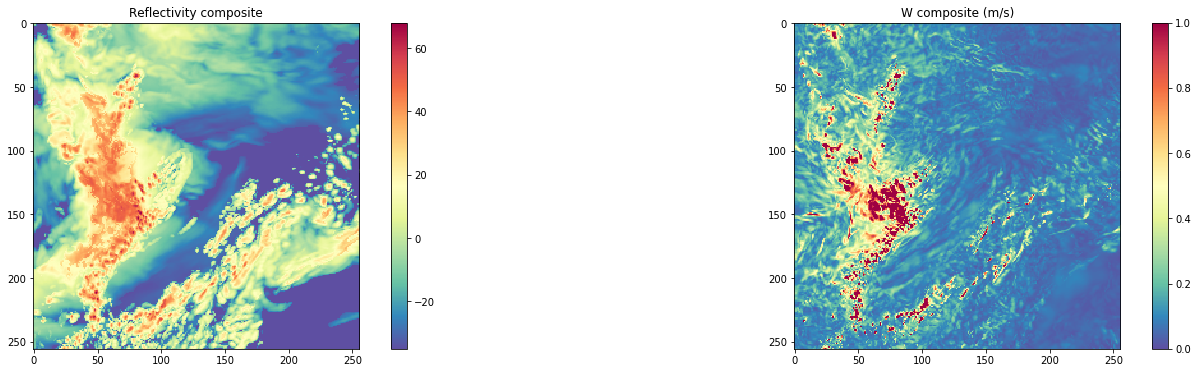

In [38]:
cmap = plt.cm.Spectral_r
plt.clf()

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(25,6)) 

max_ref = np.amax(fi[:,:])
p_ref = np.percentile(fi[:,:], 99.9)

ref = ax1.imshow(fi, cmap=cmap)
#ax1.set_title("max QRAIN 0-6.5km AGL")
ax1.set_title("Reflectivity composite")
#ref.set_clim(vmin=0, vmax=max_ref)
ref.set_clim()
fig.colorbar(ref, ax=ax1, orientation='vertical', label='')

max_maxW = np.amax(li[:,:])
min_maxW = np.amin(li[:,:])
p_maxW = np.percentile(li[:,:], 99.9)
pmin_maxW = np.percentile(li[:,:], 35.0)
print(min_maxW, max_maxW, pmin_maxW, p_maxW)

maxW = ax2.imshow(li, cmap=cmap)
ax2.set_title("W composite (m/s)")
#maxW.set_clim(vmin=0, vmax=p_maxW)
maxW.set_clim(0,1)
fig.colorbar(maxW, ax=ax2)

#plt.savefig(model_run_dir + "/predict_comp_" + job_number + "_" + str(plt_number) + ".png")

In [36]:
#
# changes to the colormap
#
from matplotlib.colors import ListedColormap

cmap = plt.cm.get_cmap('Spectral_r', 256)
newcolors = cmap(np.linspace(0, 1, 256))
pink = np.array([248/256, 24/256, 148/256, 1])
lt_gray = np.array([240/256, 240/256, 240/256, 1])
newcolors[:1, :] = lt_gray
mycmap = ListedColormap(newcolors)
#print(newcmap(range(12)))
#print('newcmap(np.linspace(0, 1, 12))', newcmp(np.linspace(0, 1, 12)))

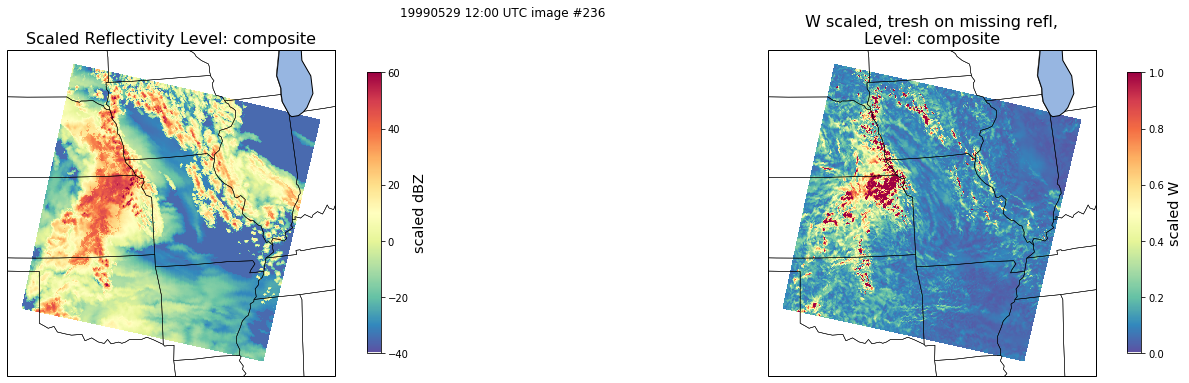

In [39]:
import cartopy.crs as ccrs
import cartopy.feature as cf

composite_refl = True
composite_W = True

#
# images with geo-referencing
#

def plot_background(ax):
    #ax.set_extent([235., 290., 20., 55.])
    #ax.set_extent([-102, -85, 30, 45])
    ax.add_feature(cf.COASTLINE.with_scale('50m'), linewidth=0.5)
    ax.add_feature(cf.STATES, linewidth=0.5)
    ax.add_feature(cf.BORDERS, linewidth=0.5)
    ax.add_feature(cf.OCEAN)
    ax.add_feature(cf.LAKES, edgecolor='black')
    ax.add_feature(cf.LAND, facecolor='white', edgecolor='none')
    #ax.add_feature(cf.LAND, facecolor='wheat', edgecolor='none')

    return ax

#
# set up plot
#
crs = ccrs.LambertConformal(central_longitude=-100.0, central_latitude=45.0)
#
#cmap = plt.cm.Spectral_r
cmap=mycmap
#
fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(25, 6), subplot_kw={'projection': crs})
fig.suptitle(full_datetime_string + ' image #' + str(plt_number))
#
axlist = axarr.flatten()
for ax in axlist:
    plot_background(ax)
#
# fi (feature image)
#
if composite_refl:
    cf1 = axlist[0].pcolormesh(lon, lat, fi, cmap=cmap, transform = ccrs.PlateCarree())
    axlist[0].set_title('Scaled Reflectivity Level: composite', fontsize=16)
else:
    cf1 = axlist[0].pcolormesh(lon, lat, fi, cmap=cmap, transform = ccrs.PlateCarree())
    axlist[0].set_title('Scaled Reflectivity Level: ' + str(refl_height+1) + ' of 10', fontsize=16)
#
cb1 = fig.colorbar(cf1, ax=axlist[0], orientation='vertical', shrink=0.86, pad=0.05)#, cmap=cmap)#, norm=norm, ticks=bounds)
cb1.mappable.set_clim(-40.0, 60.0)
cb1.set_label('scaled dBZ', size='x-large')
#
# Plotting li (label image)
#
cf2 = axlist[1].pcolormesh(lon, lat, li, cmap=cmap, transform = ccrs.PlateCarree())
if composite_W:
    axlist[1].set_title('W scaled, tresh on missing refl,\nLevel: composite', fontsize=16)
else:
    axlist[1].set_title('W Level: ' + str(W_height+1) + ' of 51', fontsize=16)
#
cb2 = fig.colorbar(cf2, ax=axlist[1], orientation='vertical', shrink=0.86, pad=0.05, 
                   cmap=cmap)#, norm=norm, ticks=bounds, extend='both', boundaries=[-10] + bounds + [10], spacing='uniform', extendfrac='auto')
cb2.mappable.set_clim(0,1.0)
cb2.set_label('scaled W', size='x-large')
#
# output_filename = 'predict-' + model_run + '-' + yearMonthDay
# output_filename = output_filename + '-image' + str(plt_number) + '.png'
# of = os.path.join(model_run_dir, output_filename)
#
# Write output file
#
# print('Writing image to output file', of)
# print()
#plt.savefig(of)

In [18]:
#animation = camera.animate(interval=500, repeat_delay=1000, repeat=20)
#output_file = os.path.join(output_path, predict_ID + '.gif')
#animation.save(output_file, writer = 'imagemagick')